In [15]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from focal_loss import SparseCategoricalFocalLoss

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [16]:
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

In [17]:
data_path = '/home/halde/cs229-falldetection/data_clean.csv'
labels_path = '/home/halde/cs229-falldetection/processedLabels.csv'

In [18]:
def load_pose_landmarks(csv_path, labels_path):
    """Loads a CSV created by MoveNetPreprocessor.
    Returns:
        X: Detected landmark coordinates and scores of shape (N, 17 * 3)
        y: Ground truth labels of shape (N, label_count)
        classes: The list of all class names found in the dataset
        dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
        truth labels (y) to use later to train a pose classification model.
    """

    # Load the CSV file
    dataframe = pd.read_csv(csv_path)
    labels = pd.read_csv(labels_path, header=None)
    df_to_process = dataframe.copy()

    # Drop the file_name columns as you don't need it during training.
    df_to_process.drop(columns=['file_name'], inplace=True)

    # Extract the list of class names
    df_to_process.pop('class_name')
    df_to_process.pop('class_no')

    # Extract the labels
    y = labels
    classes = range(8)

    # Convert the input features and labels into the correct format for training.
    X = df_to_process.astype('float64')
    y = keras.utils.to_categorical(y)
    
    return X, y, classes, dataframe

In [19]:
# Load the train data
X, y, class_names, _ = load_pose_landmarks(data_path, labels_path)
print(X.shape, y.shape)

# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)

# 80/10/10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1) # 0.25 x 0.8 = 0.2

#print(X_train.shape, X_val.shape, X_test.shape)

#60/20/20
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

(12820, 51) (12820, 8)


In [42]:
print("TRAIN DISTRIBUTION")

sample_dist = []
for i in range(0,8):
    
    num_i = 0
    for sample in y_train:
            if tf.argmax(sample) == i:
                num_i+=1
    dist = num_i/len(y_train)
    print(f"{i}: {dist}")
    sample_dist.append(dist)


print("\nTEST DISTRIBUTION")
for i in range(0,8):
    
    num_i = 0
    for sample in y_test:
            if tf.argmax(sample) == i:
                num_i+=1

    dist = num_i/len(y_test)
    print(f"{i}: {dist}")
    #sample_dist.append(dist)

TRAIN DISTRIBUTION
0: 9.750390015600624e-05
1: 0.5123829953198128
2: 0.24015210608424337
3: 0.11008190327613104
4: 0.044266770670826835
5: 0.02379095163806552
6: 0.008677847113884555
7: 0.06054992199687988

TEST DISTRIBUTION
0: 0.0
1: 0.5101404056162246
2: 0.25195007800312014
3: 0.10218408736349453
4: 0.039781591263650544
5: 0.035101404056162244
6: 0.0070202808112324495
7: 0.05382215288611544


In [43]:
sample_dist = sample_dist/np.linalg.norm(sample_dist)
weight_balanced= [1/s for s in sample_dist]

print(sample_dist)
print(weight_balanced)

sample_weights = weight_balanced


[1.67564495e-04 8.80551420e-01 4.12711351e-01 1.89180315e-01
 7.60742806e-02 4.08857367e-02 1.49132400e-02 1.04057551e-01]
[5967.851372143914, 1.1356520213404213, 2.4230009631116176, 5.285962242820119, 13.14504707520686, 24.458407262884894, 67.05450979936981, 9.610066621809844]


In [44]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
    """Calculates the center point of the two given landmarks."""
    
    left = tf.gather(landmarks, left_bodypart.value, axis=1)
    right = tf.gather(landmarks, right_bodypart.value, axis=1)
    center = left * 0.5 + right * 0.5
    return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
    """Calculates pose size.

        It is the maximum of two values:
        * Torso size multiplied by `torso_size_multiplier`
        * Maximum distance from pose center to any pose landmark
    """
    # Hips center
    hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

    # Shoulders center
    shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

    # Torso size as the minimum body size
    torso_size = tf.linalg.norm(shoulders_center - hips_center)

    # Pose center
    pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
    pose_center_new = tf.expand_dims(pose_center_new, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to
    # perform substraction
    pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

    # Dist to pose center
    d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
    # Max dist to pose center
    max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

    # Normalize scale
    pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

    return pose_size


def normalize_pose_landmarks(landmarks):
    """Normalizes the landmarks translation by moving the pose center to (0,0) and
        scaling it to a constant pose size.
    """
    # Move landmarks so that the pose center becomes (0,0)
    pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
    pose_center = tf.expand_dims(pose_center, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to perform
    # substraction
    pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
    landmarks = landmarks - pose_center

    # Scale the landmarks to a constant pose size
    pose_size = get_pose_size(landmarks)
    landmarks /= pose_size

    return landmarks


def landmarks_to_embedding(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Normalize landmarks 2D
    landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

    # Flatten the normalized landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks)

    return embedding

def no_normalization(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    landmarks = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Flatten the landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks[:, :, :2])

    return embedding

In [45]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """Plots the confusion matrix."""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [59]:
def focal_loss(gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002
        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]
        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})
        Returns:
            [tensor] -- loss.
        """
        
        epsilon = 1.e-9
        #y_true = tf.convert_to_tensor(y_true, tf.float65)
        #y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

## No normalizing at all

In [60]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = no_normalization(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 51)]              0         
                                                                 
 reshape_5 (Reshape)         (None, 17, 3)             0         
                                                                 
 tf.__operators__.getitem_5   (None, 17, 2)            0         
 (SlicingOpLambda)                                               
                                                                 
 flatten_5 (Flatten)         (None, 34)                0         
                                                                 
 dense_15 (Dense)            (None, 128)               4480      
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                           

In [61]:
print(sample_weight)

[1.135652005397082, 2.4230009290952763, 5.285962168610864, 13.145046890664462, 24.458406919515024, 67.05450885799625, 9.610066486894793]


In [62]:
#USING FOCAL LOSS

import tensorflow_addons as tfa
fl = tfa.losses.SigmoidFocalCrossEntropy()

In [67]:
model.compile(
    optimizer='adam',
    loss=tfa.losses.SigmoidFocalCrossEntropy(),
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
#checkpoint_path = "weights.best.hdf5"

checkpoint_path = "weights.best.801010split"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

# Start training

history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
614/641 [===========================>..] - ETA: 0s - loss: 0.2477 - accuracy: 0.5177
Epoch 1: val_accuracy improved from -inf to 0.50468, saving model to weights.best.801010split
INFO:tensorflow:Assets written to: weights.best.801010split/assets
641/641 [==============================] - 3s 3ms/step - loss: 0.2479 - accuracy: 0.5171 - val_loss: 0.2418 - val_accuracy: 0.5047
Epoch 2/200
626/641 [============================>.] - ETA: 0s - loss: 0.2460 - accuracy: 0.5238
Epoch 2: val_accuracy improved from 0.50468 to 0.52652, saving model to weights.best.801010split
INFO:tensorflow:Assets written to: weights.best.801010split/assets
641/641 [==============================] - 2s 3ms/step - loss: 0.2457 - accuracy: 0.5241 - val_loss: 0.2389 - val_accuracy: 0.5265
Epoch 3/200
626/641 [============================>.] - ETA: 0s - loss: 0.2439 - accuracy: 0.5269
Epoch 3: val_accuracy did not improve from 0.52652
641/641 [==============================] - 1s 2ms/step - loss: 0.2437 -

625/641 [============================>.] - ETA: 0s - loss: 0.2335 - accuracy: 0.5582
Epoch 27: val_accuracy did not improve from 0.66459
641/641 [==============================] - 1s 2ms/step - loss: 0.2334 - accuracy: 0.5583 - val_loss: 0.2100 - val_accuracy: 0.6006
Epoch 28/200
623/641 [============================>.] - ETA: 0s - loss: 0.2323 - accuracy: 0.5756
Epoch 28: val_accuracy did not improve from 0.66459
641/641 [==============================] - 1s 2ms/step - loss: 0.2316 - accuracy: 0.5769 - val_loss: 0.2014 - val_accuracy: 0.6482
Epoch 29/200
618/641 [===========================>..] - ETA: 0s - loss: 0.2301 - accuracy: 0.5775
Epoch 29: val_accuracy did not improve from 0.66459
641/641 [==============================] - 1s 2ms/step - loss: 0.2302 - accuracy: 0.5766 - val_loss: 0.2107 - val_accuracy: 0.6560
Epoch 30/200
624/641 [============================>.] - ETA: 0s - loss: 0.2303 - accuracy: 0.5650
Epoch 30: val_accuracy did not improve from 0.66459
641/641 [===========

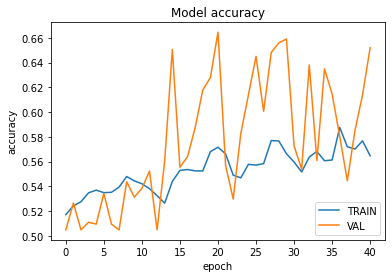

In [68]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [107]:
# Evaluate the model using the TEST dataset
loss, accuracy = model.evaluate(X_test, y_test)

41/41 [==============================] - 0s 2ms/step - loss: 0.1212 - accuracy: 0.7730


Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

           1       0.98      0.79      0.88       654
           2       0.70      0.89      0.78       323
           3       0.62      0.79      0.70       131
           4       0.42      0.43      0.43        51
           5       0.77      0.60      0.68        45
           6       0.28      1.00      0.44         9
           7       0.43      0.33      0.38        69

    accuracy                           0.77      1282
   macro avg       0.60      0.69      0.61      1282
weighted avg       0.81      0.77      0.78      1282



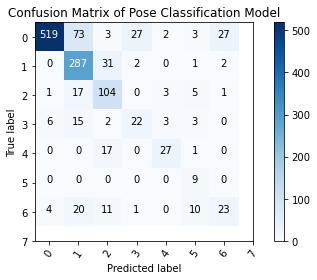

In [108]:
# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

## Normalize everything

In [90]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 51)]         0           []                               
                                                                                                  
 reshape_9 (Reshape)            (None, 17, 3)        0           ['input_10[0][0]']               
                                                                                                  
 tf.__operators__.getitem_9 (Sl  (None, 17, 2)       0           ['reshape_9[0][0]']              
 icingOpLambda)                                                                                   
                                                                                                  
 tf.compat.v1.gather_18 (TFOpLa  (None, 2)           0           ['tf.__operators__.getitem_

 a)                                                                                               
                                                                                                  
 tf.math.multiply_21 (TFOpLambd  (None, 2)           0           ['tf.compat.v1.gather_21[0][0]'] 
 a)                                                                                               
                                                                                                  
 tf.broadcast_to_5 (TFOpLambda)  (None, 17, 2)       0           ['tf.expand_dims_5[0][0]',       
                                                                  'tf.compat.v1.floor_div_5[0][0]'
                                                                 ]                                
                                                                                                  
 tf.__operators__.add_10 (TFOpL  (None, 2)           0           ['tf.math.multiply_22[0][0]',    
 ambda)   

In [109]:
model.compile(
    optimizer='adam',
    loss=tfa.losses.SigmoidFocalCrossEntropy(),
    metrics=['accuracy'],
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
#checkpoint_path = "weights.best.hdf5"

checkpoint_path = "weights.best.801010split"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
627/641 [============================>.] - ETA: 0s - loss: 0.0765 - accuracy: 0.8717
Epoch 1: val_accuracy improved from -inf to 0.91186, saving model to weights.best.801010split
INFO:tensorflow:Assets written to: weights.best.801010split/assets
641/641 [==============================] - 4s 5ms/step - loss: 0.0763 - accuracy: 0.8722 - val_loss: 0.0547 - val_accuracy: 0.9119
Epoch 2/200
626/641 [============================>.] - ETA: 0s - loss: 0.0783 - accuracy: 0.8703
Epoch 2: val_accuracy improved from 0.91186 to 0.91264, saving model to weights.best.801010split
INFO:tensorflow:Assets written to: weights.best.801010split/assets
641/641 [==============================] - 3s 5ms/step - loss: 0.0786 - accuracy: 0.8698 - val_loss: 0.0532 - val_accuracy: 0.9126
Epoch 3/200
626/641 [============================>.] - ETA: 0s - loss: 0.0749 - accuracy: 0.8714
Epoch 3: val_accuracy did not improve from 0.91264
641/641 [==============================] - 1s 2ms/step - loss: 0.0755 -

Epoch 28/200
624/641 [============================>.] - ETA: 0s - loss: 0.0745 - accuracy: 0.8731
Epoch 28: val_accuracy did not improve from 0.91888
641/641 [==============================] - 1s 2ms/step - loss: 0.0747 - accuracy: 0.8726 - val_loss: 0.0549 - val_accuracy: 0.9103
Epoch 29/200
641/641 [==============================] - ETA: 0s - loss: 0.0725 - accuracy: 0.8770
Epoch 29: val_accuracy did not improve from 0.91888
641/641 [==============================] - 1s 2ms/step - loss: 0.0725 - accuracy: 0.8770 - val_loss: 0.0556 - val_accuracy: 0.9072
Epoch 30/200
638/641 [============================>.] - ETA: 0s - loss: 0.0734 - accuracy: 0.8797
Epoch 30: val_accuracy did not improve from 0.91888
641/641 [==============================] - 1s 2ms/step - loss: 0.0736 - accuracy: 0.8792 - val_loss: 0.0548 - val_accuracy: 0.9134
Epoch 31/200
629/641 [============================>.] - ETA: 0s - loss: 0.0737 - accuracy: 0.8752
Epoch 31: val_accuracy did not improve from 0.91888
641/641

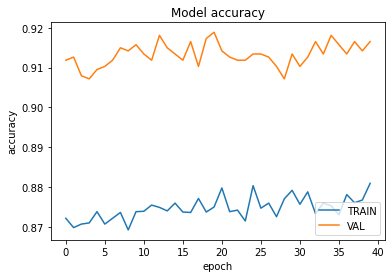

In [110]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [111]:
# Evaluate the model using the TEST dataset
loss, accuracy = model.evaluate(X_test, y_test)

41/41 [==============================] - 0s 2ms/step - loss: 0.1388 - accuracy: 0.7371


Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

           1       0.98      0.75      0.85       654
           2       0.64      0.81      0.71       323
           3       0.54      0.88      0.67       131
           4       0.47      0.37      0.42        51
           5       0.76      0.36      0.48        45
           6       0.26      1.00      0.42         9
           7       0.56      0.49      0.52        69

    accuracy                           0.74      1282
   macro avg       0.60      0.67      0.58      1282
weighted avg       0.79      0.74      0.75      1282



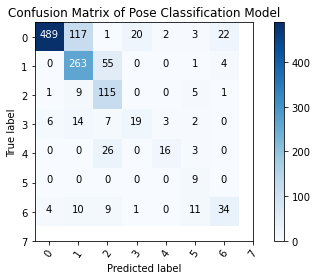

In [112]:
# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

## No normalizing size

In [113]:
def normalize_pose_landmarks_norescale(landmarks):
    """Normalizes the landmarks translation by moving the pose center to (0,0) and
        scaling it to a constant pose size.
    """
    # Move landmarks so that the pose center becomes (0,0)
    pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
    pose_center = tf.expand_dims(pose_center, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to perform
    # substraction
    pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
    landmarks = landmarks - pose_center

    return landmarks
def landmarks_to_embedding_norescale(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Normalize landmarks 2D
    landmarks = normalize_pose_landmarks_norescale(reshaped_inputs[:, :, :2])

    # Flatten the normalized landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks)

    return embedding

In [114]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding_norescale(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model2 = keras.Model(inputs, outputs)
model2.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 51)]         0           []                               
                                                                                                  
 reshape_12 (Reshape)           (None, 17, 3)        0           ['input_13[0][0]']               
                                                                                                  
 tf.__operators__.getitem_12 (S  (None, 17, 2)       0           ['reshape_12[0][0]']             
 licingOpLambda)                                                                                  
                                                                                                  
 tf.compat.v1.gather_36 (TFOpLa  (None, 2)           0           ['tf.__operators__.getitem

In [115]:
model2.compile(
    optimizer='adam',
    loss=tfa.losses.SigmoidFocalCrossEntropy(),
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.801010splitnonormsize"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

# Start training
history2 = model2.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
619/641 [===========================>..] - ETA: 0s - loss: 0.7082 - accuracy: 0.4292
Epoch 1: val_accuracy improved from -inf to 0.54212, saving model to weights.best.801010splitnonormsize
INFO:tensorflow:Assets written to: weights.best.801010splitnonormsize/assets
641/641 [==============================] - 3s 4ms/step - loss: 0.6941 - accuracy: 0.4338 - val_loss: 0.2330 - val_accuracy: 0.5421
Epoch 2/200
640/641 [============================>.] - ETA: 0s - loss: 0.2630 - accuracy: 0.5478
Epoch 2: val_accuracy improved from 0.54212 to 0.54290, saving model to weights.best.801010splitnonormsize
INFO:tensorflow:Assets written to: weights.best.801010splitnonormsize/assets
641/641 [==============================] - 2s 4ms/step - loss: 0.2628 - accuracy: 0.5477 - val_loss: 0.2063 - val_accuracy: 0.5429
Epoch 3/200
614/641 [===========================>..] - ETA: 0s - loss: 0.2278 - accuracy: 0.5780
Epoch 3: val_accuracy improved from 0.54290 to 0.58502, saving model to weights.be

INFO:tensorflow:Assets written to: weights.best.801010splitnonormsize/assets
641/641 [==============================] - 2s 4ms/step - loss: 0.1224 - accuracy: 0.7937 - val_loss: 0.0838 - val_accuracy: 0.8619
Epoch 25/200
618/641 [===========================>..] - ETA: 0s - loss: 0.1216 - accuracy: 0.7910
Epoch 25: val_accuracy did not improve from 0.86193
641/641 [==============================] - 1s 2ms/step - loss: 0.1217 - accuracy: 0.7909 - val_loss: 0.0819 - val_accuracy: 0.8604
Epoch 26/200
620/641 [============================>.] - ETA: 0s - loss: 0.1199 - accuracy: 0.7949
Epoch 26: val_accuracy improved from 0.86193 to 0.87051, saving model to weights.best.801010splitnonormsize
INFO:tensorflow:Assets written to: weights.best.801010splitnonormsize/assets
641/641 [==============================] - 3s 4ms/step - loss: 0.1198 - accuracy: 0.7945 - val_loss: 0.0827 - val_accuracy: 0.8705
Epoch 27/200
617/641 [===========================>..] - ETA: 0s - loss: 0.1166 - accuracy: 0.8018

641/641 [==============================] - 1s 2ms/step - loss: 0.1065 - accuracy: 0.8255 - val_loss: 0.0728 - val_accuracy: 0.8908
Epoch 52/200
622/641 [============================>.] - ETA: 0s - loss: 0.1058 - accuracy: 0.8227
Epoch 52: val_accuracy did not improve from 0.89626
641/641 [==============================] - 1s 2ms/step - loss: 0.1058 - accuracy: 0.8230 - val_loss: 0.0710 - val_accuracy: 0.8892
Epoch 53/200
620/641 [============================>.] - ETA: 0s - loss: 0.1087 - accuracy: 0.8206
Epoch 53: val_accuracy did not improve from 0.89626
641/641 [==============================] - 1s 2ms/step - loss: 0.1083 - accuracy: 0.8213 - val_loss: 0.0760 - val_accuracy: 0.8947
Epoch 54/200
640/641 [============================>.] - ETA: 0s - loss: 0.1059 - accuracy: 0.8242
Epoch 54: val_accuracy did not improve from 0.89626
641/641 [==============================] - 1s 2ms/step - loss: 0.1060 - accuracy: 0.8241 - val_loss: 0.0698 - val_accuracy: 0.8963
Epoch 55/200
614/641 [====

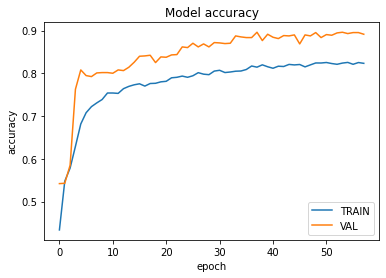

In [116]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [117]:
loss, accuracy = model2.evaluate(X_test, y_test)

41/41 [==============================] - 0s 1ms/step - loss: 0.0799 - accuracy: 0.8612


Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

           1       0.98      0.75      0.85       654
           2       0.64      0.81      0.71       323
           3       0.54      0.88      0.67       131
           4       0.47      0.37      0.42        51
           5       0.76      0.36      0.48        45
           6       0.26      1.00      0.42         9
           7       0.56      0.49      0.52        69

    accuracy                           0.74      1282
   macro avg       0.60      0.67      0.58      1282
weighted avg       0.79      0.74      0.75      1282



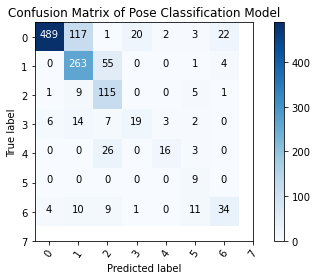

In [118]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """Plots the confusion matrix."""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

## No normalizing position

In [119]:
def normalize_pose_landmarks_noreposition(landmarks):
    """Normalizes the landmarks translation by moving the pose center to (0,0) and
        scaling it to a constant pose size.
    """
   # Scale the landmarks to a constant pose size
    pose_size = get_pose_size(landmarks)
    landmarks /= pose_size

    return landmarks
def landmarks_to_embedding_norescale(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Normalize landmarks 2D
    landmarks = normalize_pose_landmarks_noreposition(reshaped_inputs[:, :, :2])

    # Flatten the normalized landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks)

    return embedding

In [120]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding_norescale(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model2 = keras.Model(inputs, outputs)
model2.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 51)]         0           []                               
                                                                                                  
 reshape_13 (Reshape)           (None, 17, 3)        0           ['input_14[0][0]']               
                                                                                                  
 tf.__operators__.getitem_13 (S  (None, 17, 2)       0           ['reshape_13[0][0]']             
 licingOpLambda)                                                                                  
                                                                                                  
 tf.compat.v1.gather_42 (TFOpLa  (None, 2)           0           ['tf.__operators__.getitem

 tf.math.multiply_44 (TFOpLambd  ()                  0           ['tf.compat.v1.norm_8[0][0]']    
 a)                                                                                               
                                                                                                  
 tf.math.reduce_max_4 (TFOpLamb  ()                  0           ['tf.compat.v1.norm_9[0][0]']    
 da)                                                                                              
                                                                                                  
 tf.math.maximum_4 (TFOpLambda)  ()                  0           ['tf.math.multiply_44[0][0]',    
                                                                  'tf.math.reduce_max_4[0][0]']   
                                                                                                  
 tf.math.truediv_4 (TFOpLambda)  (None, 17, 2)       0           ['tf.__operators__.getitem_13[0][
          

In [121]:
model2.compile(
    optimizer='adam',
    loss=tfa.losses.SigmoidFocalCrossEntropy(),
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.801010splitnonormsize"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

# Start training
history2 = model2.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
629/641 [============================>.] - ETA: 0s - loss: 0.2386 - accuracy: 0.5561
Epoch 1: val_accuracy improved from -inf to 0.68487, saving model to weights.best.801010splitnonormsize
INFO:tensorflow:Assets written to: weights.best.801010splitnonormsize/assets
641/641 [==============================] - 4s 5ms/step - loss: 0.2378 - accuracy: 0.5587 - val_loss: 0.1740 - val_accuracy: 0.6849
Epoch 2/200
622/641 [============================>.] - ETA: 0s - loss: 0.1855 - accuracy: 0.6693
Epoch 2: val_accuracy improved from 0.68487 to 0.70359, saving model to weights.best.801010splitnonormsize
INFO:tensorflow:Assets written to: weights.best.801010splitnonormsize/assets
641/641 [==============================] - 3s 4ms/step - loss: 0.1845 - accuracy: 0.6704 - val_loss: 0.1581 - val_accuracy: 0.7036
Epoch 3/200
635/641 [============================>.] - ETA: 0s - loss: 0.1747 - accuracy: 0.6942
Epoch 3: val_accuracy improved from 0.70359 to 0.71919, saving model to weights.be

635/641 [============================>.] - ETA: 0s - loss: 0.1414 - accuracy: 0.7446
Epoch 25: val_accuracy did not improve from 0.78237
641/641 [==============================] - 1s 2ms/step - loss: 0.1414 - accuracy: 0.7441 - val_loss: 0.1223 - val_accuracy: 0.7590
Epoch 26/200
630/641 [============================>.] - ETA: 0s - loss: 0.1397 - accuracy: 0.7512
Epoch 26: val_accuracy did not improve from 0.78237
641/641 [==============================] - 1s 2ms/step - loss: 0.1394 - accuracy: 0.7513 - val_loss: 0.1192 - val_accuracy: 0.7715
Epoch 27/200
634/641 [============================>.] - ETA: 0s - loss: 0.1413 - accuracy: 0.7470
Epoch 27: val_accuracy improved from 0.78237 to 0.79407, saving model to weights.best.801010splitnonormsize
INFO:tensorflow:Assets written to: weights.best.801010splitnonormsize/assets
641/641 [==============================] - 3s 4ms/step - loss: 0.1410 - accuracy: 0.7476 - val_loss: 0.1160 - val_accuracy: 0.7941
Epoch 28/200
625/641 [===============

633/641 [============================>.] - ETA: 0s - loss: 0.1312 - accuracy: 0.7667
Epoch 52: val_accuracy improved from 0.80811 to 0.80889, saving model to weights.best.801010splitnonormsize
INFO:tensorflow:Assets written to: weights.best.801010splitnonormsize/assets
641/641 [==============================] - 3s 4ms/step - loss: 0.1317 - accuracy: 0.7668 - val_loss: 0.1053 - val_accuracy: 0.8089
Epoch 53/200
626/641 [============================>.] - ETA: 0s - loss: 0.1325 - accuracy: 0.7633
Epoch 53: val_accuracy did not improve from 0.80889
641/641 [==============================] - 1s 2ms/step - loss: 0.1327 - accuracy: 0.7635 - val_loss: 0.1050 - val_accuracy: 0.8050
Epoch 54/200
636/641 [============================>.] - ETA: 0s - loss: 0.1313 - accuracy: 0.7626
Epoch 54: val_accuracy did not improve from 0.80889
641/641 [==============================] - 1s 2ms/step - loss: 0.1312 - accuracy: 0.7628 - val_loss: 0.1070 - val_accuracy: 0.8089
Epoch 55/200
623/641 [===============

641/641 [==============================] - 3s 4ms/step - loss: 0.1244 - accuracy: 0.7802 - val_loss: 0.1020 - val_accuracy: 0.8385
Epoch 79/200
640/641 [============================>.] - ETA: 0s - loss: 0.1248 - accuracy: 0.7804
Epoch 79: val_accuracy did not improve from 0.83853
641/641 [==============================] - 1s 2ms/step - loss: 0.1247 - accuracy: 0.7805 - val_loss: 0.0999 - val_accuracy: 0.8206
Epoch 80/200
631/641 [============================>.] - ETA: 0s - loss: 0.1259 - accuracy: 0.7738
Epoch 80: val_accuracy did not improve from 0.83853
641/641 [==============================] - 1s 2ms/step - loss: 0.1263 - accuracy: 0.7727 - val_loss: 0.1008 - val_accuracy: 0.8089
Epoch 81/200
635/641 [============================>.] - ETA: 0s - loss: 0.1250 - accuracy: 0.7746
Epoch 81: val_accuracy did not improve from 0.83853
641/641 [==============================] - 1s 2ms/step - loss: 0.1252 - accuracy: 0.7748 - val_loss: 0.1010 - val_accuracy: 0.8214
Epoch 82/200
638/641 [====

619/641 [===========================>..] - ETA: 0s - loss: 0.1238 - accuracy: 0.7797
Epoch 107: val_accuracy did not improve from 0.84165
641/641 [==============================] - 1s 2ms/step - loss: 0.1235 - accuracy: 0.7797 - val_loss: 0.0963 - val_accuracy: 0.8128
Epoch 108/200
640/641 [============================>.] - ETA: 0s - loss: 0.1228 - accuracy: 0.7833
Epoch 108: val_accuracy did not improve from 0.84165
641/641 [==============================] - 1s 2ms/step - loss: 0.1229 - accuracy: 0.7831 - val_loss: 0.0910 - val_accuracy: 0.8362


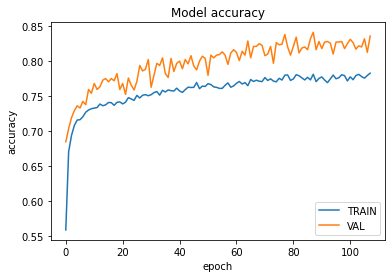

In [122]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [123]:
loss, accuracy = model2.evaluate(X_test, y_test)

41/41 [==============================] - 0s 2ms/step - loss: 0.1796 - accuracy: 0.6279


Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

           1       0.98      0.75      0.85       654
           2       0.64      0.81      0.71       323
           3       0.54      0.88      0.67       131
           4       0.47      0.37      0.42        51
           5       0.76      0.36      0.48        45
           6       0.26      1.00      0.42         9
           7       0.56      0.49      0.52        69

    accuracy                           0.74      1282
   macro avg       0.60      0.67      0.58      1282
weighted avg       0.79      0.74      0.75      1282



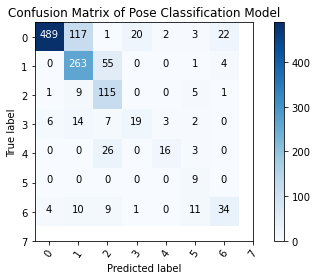

In [124]:
# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))